In [54]:
!pip install osmnx
!pip install ortools

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import folium
import plotly.express as px
from folium.plugins import HeatMap
import osmnx as ox # This should work after installing osmnx
import networkx as nx
from ortools.constraint_solver import pywrapcp # Fixed the typo here: comstraint_solver to constraint_solver
from ortools.constraint_solver import routing_enums_pb2
from geopy.geocoders import Nominatim

In [ ]:
city = "London"
dataF = pd.read_csv("/content/data_stores.csv")
dataF = dataF[dataF["City"]==city][["City","Street Address","Latitude","Longitude"]].reset_index(drop=True)
dataF = dataF.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})
print("total", len(dataF))
dataF.head()

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23
3,3,London,1442 Fanshawe Park Road,43.01,-81.34
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26


In [ ]:
data = dataF.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [58]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row: folium.CircleMarker( location=[row["y"], row["x"]], color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

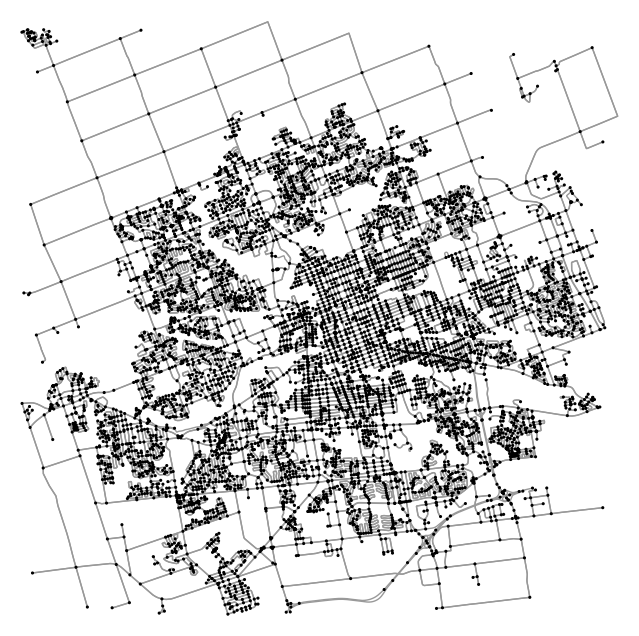

In [59]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="white", node_size=5 , node_color="black", figsize=(16,8))

In [ ]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dataF["node"]=dataF[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dataF=dataF.drop_duplicates("node", keep='first')
dataF.head()

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [ ]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dataF["node"].tolist()] for a in dataF["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dataF["node"].values, index=dataF["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.000000,562.866913,353.049506,594.714108,498.758604,403.372848,126.556124,393.757943,554.836209,101.785103,514.110793,435.289070,233.314271,198.986748,567.090496,226.311910,523.061847,477.118587,1034.600392,1047.016739
324811692,590.165537,0.000000,210.854848,1099.746751,950.716467,713.164777,458.102651,871.443311,736.594940,489.689320,402.673944,890.465725,670.108445,403.238530,680.745919,777.674476,119.618320,982.151231,1311.267733,782.678630
11756886360,379.310690,209.817407,0.000000,913.372457,739.861619,579.159804,247.247803,660.588464,550.220645,278.834473,412.588905,704.091431,459.253598,192.383682,582.663260,579.416252,239.882201,795.776936,1201.745855,915.029524
252974916,592.990749,1096.634969,915.098285,0.000000,428.970799,858.411680,704.917253,323.970139,481.421944,665.849247,725.879492,356.012806,500.973868,764.561415,1083.612485,433.006683,1026.220894,174.877318,1306.665725,979.761399
302754873,498.682321,951.741646,741.924239,430.052371,0.000000,480.687036,573.160420,107.371772,892.111380,513.652163,865.103577,764.835921,348.776784,568.958120,705.887841,395.060603,981.595227,312.456850,928.941081,1390.450836


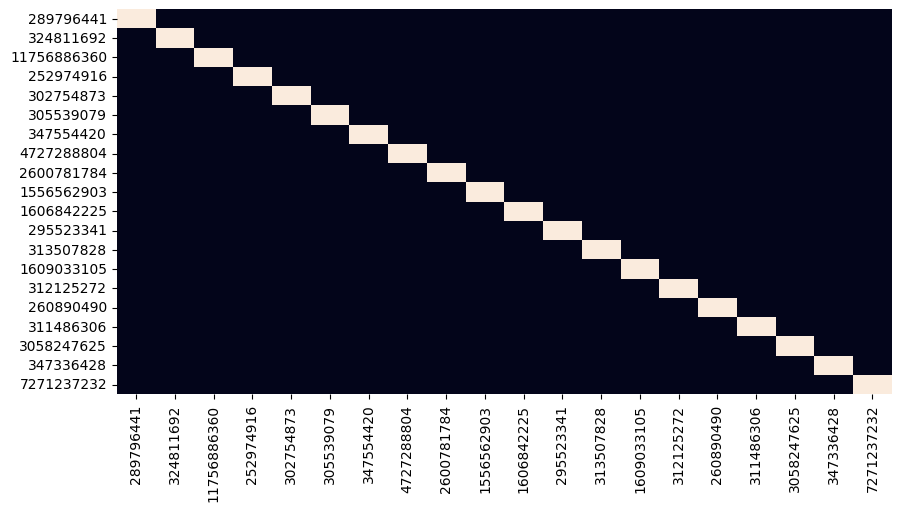

In [62]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [63]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,563,353,595,499,403,127,394,555,102,514,435,233,199,567,226,523,477,1035,1047
324811692,590,0,211,1100,951,713,458,871,737,490,403,890,670,403,681,778,120,982,1311,783
11756886360,379,210,0,913,740,579,247,661,550,279,413,704,459,192,583,579,240,796,1202,915
252974916,593,1097,915,0,429,858,705,324,481,666,726,356,501,765,1084,433,1026,175,1307,980
302754873,499,952,742,430,0,481,573,107,892,514,865,765,349,569,706,395,982,312,929,1390
305539079,403,645,583,861,485,0,436,539,894,376,867,767,411,410,309,558,747,744,688,1363
347554420,150,456,246,716,572,435,0,467,520,92,479,518,265,93,491,350,425,598,1067,1012
4727288804,391,869,659,323,107,537,466,0,785,406,758,657,241,505,762,288,874,205,985,1283
2600781784,555,732,550,478,887,890,521,782,0,603,361,185,720,578,1002,563,662,633,1521,633
1556562903,170,488,278,668,512,376,92,407,603,0,562,538,206,124,492,336,501,551,1007,1095


In [ ]:
drivers = 1
lst_nodes = dataF["node"].to_list()
print("starting point:", start_node, "| Total loctaions to vist:", len(lst_nodes)-1, "| Drivers:",drivers)

starting point: 289796441 | Total loctaions to vist: 19 | Drivers: 1


In [65]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model= pywrapcp.RoutingModel(manager)

In [66]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance= model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [67]:
solution = model.SolveWithParameters(parameters)
index = model.Start(0)
print('route for the driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for the driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.69km
Nodes visited: 20


In [68]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [75]:
# Function to get the path between nodes
def get_path_between_nodes(lst_route):
    lst_paths = []
    for i in range(len(lst_route) - 1):  # Avoid index error
        try:
            a, b = lst_route[i], lst_route[i+1]  # ✅ Corrected lst_route usage
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

# Generate optimized paths
lst_paths = get_path_between_nodes(lst_route)

# Use Folium's PolyLine to draw routes
from folium import PolyLine
for path in lst_paths:
    coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]  # Extract coordinates
    PolyLine(coords, color="blue", weight=2.5, opacity=1).add_to(map)  # Plot route

# Display map
map

In [81]:
def df_animation_multiple_path(G, lst_paths, parallel=True): # Changed parlle to parallel
    df = pd.DataFrame()
    for path in lst_paths:
        lst_start, lst_end = [], []
        start_x, start_y = [], []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a, b in zip(path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[a, b, 0]['length'] / 1000, 2))
            lst_time.append(round(G.edges[a, b, 0]['travel_time'] / 60, 2))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            end_x.append(G.nodes[b]['x'])  # Adding end coordinates for the line segment
            end_y.append(G.nodes[b]['y'])  # Adding end coordinates for the line segment

        # Creating temporary DataFrame for each path
        tmp = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                          columns=['start', 'end', "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])

        # Concatenating temporary DataFrame to the main DataFrame
        df = pd.concat([df, tmp], ignore_index=(not parallel))

    df = df.reset_index().rename(columns={"index": "id"})
    return df

In [82]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [ ]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dataF, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig